In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

column_names = ['Frequency', 'S11_real', 'S11_imag', 'S21_real', 'S21_imag', 'S12_real', 'S12_imag', 'S22_real', 'S22_imag']

df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
print(df.head())
print(df.tail())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     Frequency  S11_real  S11_imag  S21_real  S21_imag  S12_real  S12_imag  \
0  150000000.0  0.999581 -0.017274 -0.000068  0.003711 -0.000197  0.002876   
1  200000000.0  0.999773 -0.022917 -0.000445  0.004304  0.000066  0.004540   
2  250000000.0  0.999480 -0.028811  0.000598  0.005652  0.000257  0.005739   
3  300000000.0  0.998839 -0.034925  0.000645  0.006661  0.000504  0.006547   
4  350000000.0  0.998923 -0.040521  0.000579  0.007655  0.000185  0.008006   

   S22_real  S22_imag  Drain Voltage  Gate Voltage  
0 -0.194988 -0.001711            0.0          -4.0  
1 -0.195059 -0.001605            0.0          -4.0  
2 -0.194959 -0.002238            0.0          -4.0  
3 -0.194624 -0.003261            0.0          -4.0  
4 -0.194737 -0.003503            0.0          -4.0  
          Frequency  S11_real  S11_imag  S21_real  S21_imag  S12_real  \
60755  4.33

In [ ]:
df.describe()

Frequency      S11_real      S11_imag      S21_real      S21_imag  \
count  6.076000e+04  60760.000000  60760.000000  60760.000000  60760.000000   
mean   2.182500e+10      0.199791     -0.510623     -0.247884      0.752500   
std    1.252860e+10      0.422961      0.162620      0.653742      0.303386   
min    1.500000e+08     -0.467111     -0.958287     -1.815632     -0.028003   
25%    1.098750e+10     -0.161333     -0.642664     -0.738636      0.559766   
50%    2.182500e+10      0.061961     -0.524022     -0.007171      0.765161   
75%    3.266250e+10      0.548578     -0.411805      0.306935      0.987178   
max    4.350000e+10      1.000406     -0.009927      0.593229      1.438814   

           S12_real      S12_imag      S22_real      S22_imag  Drain Voltage  \
count  60760.000000  60760.000000  60760.000000  60760.000000    60760.00000   
mean       0.121201      0.035390      0.535566     -0.260609        8.50000   
std        0.066704      0.044674      0.241684      0.088531        2.82845   
min       -0.000434     -0.134165     -0.308115     -0.691079        0.00000   
25%        0.070913      0.003520      0.377331     -0.327240        8.50000   
50%        0.135755      0.042079      0.515895     -0.282772       10.00000   
75%        0.165853      0.070535      0.731201     -0.218516       10.00000   
max        0.371832      0.157606      0.959126      0.017057       10.00000   

       Gate Voltage  
count  60760.000000  
mean      -2.924286  
std        1.431837  
min       -5.000000  
25%       -4.000000  
50%       -3.650000  
75%       -1.700000  
max        0.000000

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1 & 2. Load and filter (f <= 1.6e10) & vd == 10
# df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
df_filtered = df[(df['Frequency'] <= 1.6e10) & (df['Drain Voltage'] == 10)]

# 3. Train/test split
train_mask = (
    (df_filtered['Gate Voltage'] >= -3.9) &
    (df_filtered['Gate Voltage'] <= 0) &
    (df_filtered['Frequency'] <= 1.4e10)
)
train_df = df_filtered[train_mask]
test_df  = df_filtered[~train_mask]

# Features & targets
X_train = train_df[['Frequency', 'Gate Voltage']].values
X_test  = test_df[['Frequency', 'Gate Voltage']].values

y_train = train_df[['S11_real', 'S11_imag']].values
y_test  = test_df[['S11_real', 'S11_imag']].values

# Scale
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_x.transform(X_train)
X_test_s  = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# Build dual-output model
def build_model():
    inp = layers.Input(shape=(2,))
    x = layers.Dense(64, activation='swish')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dense(64, activation='swish')(x)
    out_r = layers.Dense(1)(x)
    out_i = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=[out_r, out_i])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model()
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train_s, [y_train_s[:,0], y_train_s[:,1]],
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=[es],
    verbose=1
)

# Predict
pred_r, pred_i = model.predict(X_test_s)
pred_scaled = np.hstack([pred_r, pred_i])  # shape: (N, 2)
pred = scaler_y.inverse_transform(pred_scaled)
pred_real, pred_imag = pred[:, 0], pred[:, 1]

# True
true_real, true_imag = y_test[:, 0], y_test[:, 1]

# Error metrics
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

print("\n=== Test Set Error Metrics ===")
print(f"S11_real → MRE: {mean_relative_error(true_real, pred_real):.6f}, MAE: {mean_absolute_error(true_real, pred_real):.6f}, MSE: {mean_squared_error(true_real, pred_real):.6f}")
print(f"S11_imag → MRE: {mean_relative_error(true_imag, pred_imag):.6f}, MAE: {mean_absolute_error(true_imag, pred_imag):.6f}, MSE: {mean_squared_error(true_imag, pred_imag):.6f}")


Epoch 1/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - dense_16_loss: 0.0710 - dense_17_loss: 0.0836 - loss: 0.1546 - val_dense_16_loss: 0.0082 - val_dense_17_loss: 0.0031 - val_loss: 0.0111
Epoch 2/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - dense_16_loss: 0.0046 - dense_17_loss: 0.0061 - loss: 0.0107 - val_dense_16_loss: 0.0031 - val_dense_17_loss: 8.0960e-04 - val_loss: 0.0038
Epoch 3/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_16_loss: 0.0042 - dense_17_loss: 0.0052 - loss: 0.0095 - val_dense_16_loss: 0.0034 - val_dense_17_loss: 2.8971e-04 - val_loss: 0.0037
Epoch 4/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - dense_16_loss: 0.0046 - dense_17_loss: 0.0048 - loss: 0.0093 - val_dense_16_loss: 0.0028 - val_dense_17_loss: 0.0014 - val_loss: 0.0041
Epoch 5/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_16_loss: 0.0038 - dense_17_loss: 0.0041 - loss: 0.0078 - val_dense_16_loss: 0.0016 - val_dense_17_loss: 0.0011 - val_loss: 0.0026
Epoch 6/100
1189/1189 ━━━━━

In [ ]:
def plot_and_eval_for_vg(vg_value, tol=1e-6):
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value}V")
        return

    # Prepare input
    X_sub = subset[['Frequency', 'Gate Voltage']].values
    Xs = scaler_x.transform(X_sub)

    # Predict (scaled), then inverse transform
    pred_r, pred_i = model.predict(Xs)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    pred_real, pred_imag = pred[:, 0], pred[:, 1]

    # True values
    actual_real = subset['S11_real'].values
    actual_imag = subset['S11_imag'].values

    # Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def mre(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre, real_mae, real_mse = mre(actual_real, pred_real), mean_absolute_error(actual_real, pred_real), mean_squared_error(actual_real, pred_real)
    imag_mre, imag_mae, imag_mse = mre(actual_imag, pred_imag), mean_absolute_error(actual_imag, pred_imag), mean_squared_error(actual_imag, pred_imag)

    print(f"S11_real @ VG={vg_value}V → MRE={real_mre:.6f}, MAE={real_mae:.6f}, MSE={real_mse:.6f}")
    print(f"S11_imag @ VG={vg_value}V → MRE={imag_mre:.6f}, MAE={imag_mae:.6f}, MSE={imag_mse:.6f}")

    # Plot
    freq = subset['Frequency'].values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq, actual_real, 'o', label='Actual')
    plt.plot(freq, pred_real, 'x--', label='Predicted')
    plt.title(f'S11_real @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S11_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq, actual_imag, 'o', label='Actual')
    plt.plot(freq, pred_imag, 'x--', label='Predicted')
    plt.title(f'S11_imag @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S11_imag')
    plt.legend()

    plt.tight_layout()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
S11_real @ VG=-4.2V → MRE=0.015380, MAE=0.007733, MSE=0.000107
S11_imag @ VG=-4.2V → MRE=0.029497, MAE=0.007288, MSE=0.000066


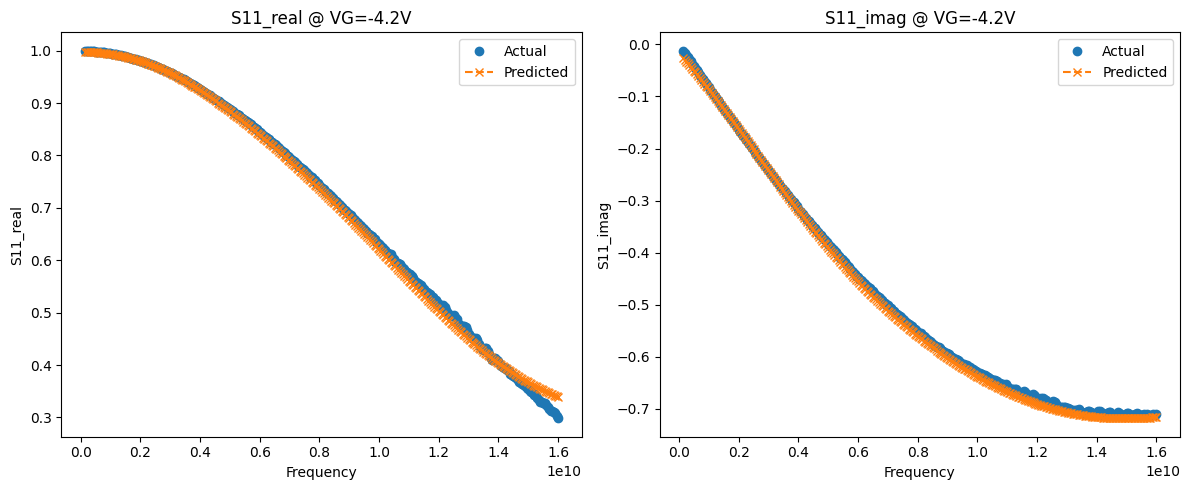

In [ ]:
plot_and_eval_for_vg(-4.2)

In [ ]:
pip install scikit-rf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.2/609.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from skrf.frequency import Frequency
from skrf.network import Network

def plot_smith_for_vg(vg_value, tol=1e-6):
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value} V")
        return

    # Actual S11
    freq = subset['Frequency'].values
    s11_actual = subset['S11_real'].values + 1j * subset['S11_imag'].values

    # Predict S11
    X = subset[['Frequency', 'Gate Voltage']].values
    X_scaled = scaler_x.transform(X)
    pred_r, pred_i = model.predict(X_scaled)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    s11_pred = pred[:, 0] + 1j * pred[:, 1]

    # Create scikit-rf networks
    freq_obj = Frequency.from_f(freq, unit='Hz')
    ntw_actual = Network(frequency=freq_obj, s=s11_actual.reshape(-1, 1, 1), name='Actual S11')
    ntw_pred = Network(frequency=freq_obj, s=s11_pred.reshape(-1, 1, 1), name='Predicted S11')

    # Plot Smith chart
    plt.figure(figsize=(8, 8))
    ntw_actual.plot_s_smith(m=0, n=0, label='Actual S11', marker='o', markersize=6, markerfacecolor='blue', linestyle='None')
    ntw_pred.plot_s_smith(m=0, n=0, label='Predicted S11', marker='.', markersize=2, linestyle='None')
    plt.title(f'Smith Chart: VG = {vg_value} V')
    plt.legend()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


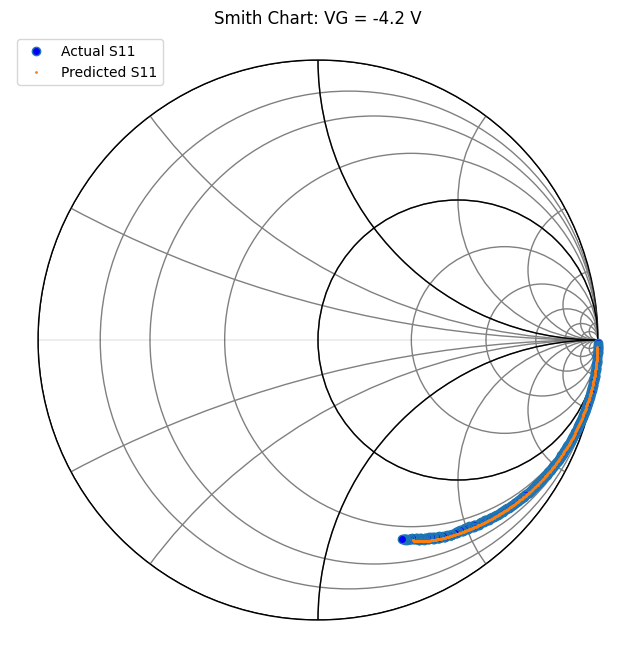

In [ ]:
plot_smith_for_vg(-4.2)

In [ ]:
# --- S22 Modeling ---
# Prepare data
y_train_s22 = train_df[['S22_real', 'S22_imag']].values
y_test_s22  = test_df[['S22_real', 'S22_imag']].values

# Scale targets
scaler_y_s22 = StandardScaler().fit(y_train_s22)
y_train_s22_scaled = scaler_y_s22.transform(y_train_s22)
y_test_s22_scaled  = scaler_y_s22.transform(y_test_s22)

# Build model
def build_model_s22():
    inp = layers.Input(shape=(2,))
    x = layers.Dense(64, activation='swish')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dense(64, activation='swish')(x)
    out_r = layers.Dense(1)(x)
    out_i = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=[out_r, out_i])
    model.compile(optimizer='adam', loss='mse')
    return model

model_s22 = build_model_s22()
es_s22 = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history_s22 = model_s22.fit(
    X_train_s, [y_train_s22_scaled[:, 0], y_train_s22_scaled[:, 1]],
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=[es_s22],
    verbose=1
)

# Predict
pred_r_s22, pred_i_s22 = model_s22.predict(X_test_s)
pred_scaled_s22 = np.hstack([pred_r_s22, pred_i_s22])
pred_s22 = scaler_y_s22.inverse_transform(pred_scaled_s22)
pred_real_s22, pred_imag_s22 = pred_s22[:, 0], pred_s22[:, 1]

# True
true_real_s22, true_imag_s22 = y_test_s22[:, 0], y_test_s22[:, 1]

# Error metrics
def mean_relative_error_s22(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

print("\n=== Test Set Error Metrics for S22 ===")
print(f"S22_real → MRE: {mean_relative_error_s22(true_real_s22, pred_real_s22):.6f}, MAE: {mean_absolute_error(true_real_s22, pred_real_s22):.6f}, MSE: {mean_squared_error(true_real_s22, pred_real_s22):.6f}")
print(f"S22_imag → MRE: {mean_relative_error_s22(true_imag_s22, pred_imag_s22):.6f}, MAE: {mean_absolute_error(true_imag_s22, pred_imag_s22):.6f}, MSE: {mean_squared_error(true_imag_s22, pred_imag_s22):.6f}")


Epoch 1/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - dense_22_loss: 0.0670 - dense_23_loss: 0.0678 - loss: 0.1349 - val_dense_22_loss: 0.0035 - val_dense_23_loss: 6.5476e-04 - val_loss: 0.0042
Epoch 2/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - dense_22_loss: 0.0060 - dense_23_loss: 0.0057 - loss: 0.0117 - val_dense_22_loss: 7.4134e-04 - val_dense_23_loss: 0.0015 - val_loss: 0.0022
Epoch 3/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - dense_22_loss: 0.0054 - dense_23_loss: 0.0057 - loss: 0.0110 - val_dense_22_loss: 0.0038 - val_dense_23_loss: 7.3109e-04 - val_loss: 0.0045
Epoch 4/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_22_loss: 0.0055 - dense_23_loss: 0.0051 - loss: 0.0106 - val_dense_22_loss: 0.0030 - val_dense_23_loss: 4.4105e-04 - val_loss: 0.0034
Epoch 5/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dense_22_loss: 0.0055 - dense_23_loss: 0.0048 - loss: 0.0103 - val_dense_22_loss: 0.0016 - val_dense_23_loss: 0.0019 - val_loss: 0.0035
Epoch 6/100
1189/1

In [ ]:
def plot_and_eval_for_vg_s22(vg_value, tol=1e-6):
    subset_s22 = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset_s22.empty:
        print(f"No data found for Gate Voltage = {vg_value}V")
        return

    # Prepare input
    X_sub_s22 = subset_s22[['Frequency', 'Gate Voltage']].values
    Xs_s22 = scaler_x.transform(X_sub_s22)

    # Predict and inverse transform
    pred_r_s22, pred_i_s22 = model_s22.predict(Xs_s22)
    pred_scaled_s22 = np.hstack([pred_r_s22, pred_i_s22])
    pred_s22 = scaler_y_s22.inverse_transform(pred_scaled_s22)
    pred_real_s22, pred_imag_s22 = pred_s22[:, 0], pred_s22[:, 1]

    # Ground truth
    actual_real_s22 = subset_s22['S22_real'].values
    actual_imag_s22 = subset_s22['S22_imag'].values

    # Metrics
    def mre_s22(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre_s22 = mre_s22(actual_real_s22, pred_real_s22)
    real_mae_s22 = mean_absolute_error(actual_real_s22, pred_real_s22)
    real_mse_s22 = mean_squared_error(actual_real_s22, pred_real_s22)

    imag_mre_s22 = mre_s22(actual_imag_s22, pred_imag_s22)
    imag_mae_s22 = mean_absolute_error(actual_imag_s22, pred_imag_s22)
    imag_mse_s22 = mean_squared_error(actual_imag_s22, pred_imag_s22)

    print(f"S22_real @ VG={vg_value}V → MRE={real_mre_s22:.6f}, MAE={real_mae_s22:.6f}, MSE={real_mse_s22:.6f}")
    print(f"S22_imag @ VG={vg_value}V → MRE={imag_mre_s22:.6f}, MAE={imag_mae_s22:.6f}, MSE={imag_mse_s22:.6f}")

    # Plot
    freq_s22 = subset_s22['Frequency'].values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq_s22, actual_real_s22, 'o', label='Actual')
    plt.plot(freq_s22, pred_real_s22, 'x--', label='Predicted')
    plt.title(f'S22_real @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S22_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq_s22, actual_imag_s22, 'o', label='Actual')
    plt.plot(freq_s22, pred_imag_s22, 'x--', label='Predicted')
    plt.title(f'S22_imag @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S22_imag')
    plt.legend()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
S22_real @ VG=-4.2V → MRE=0.007919, MAE=0.006569, MSE=0.000047
S22_imag @ VG=-4.2V → MRE=0.034962, MAE=0.003170, MSE=0.000013


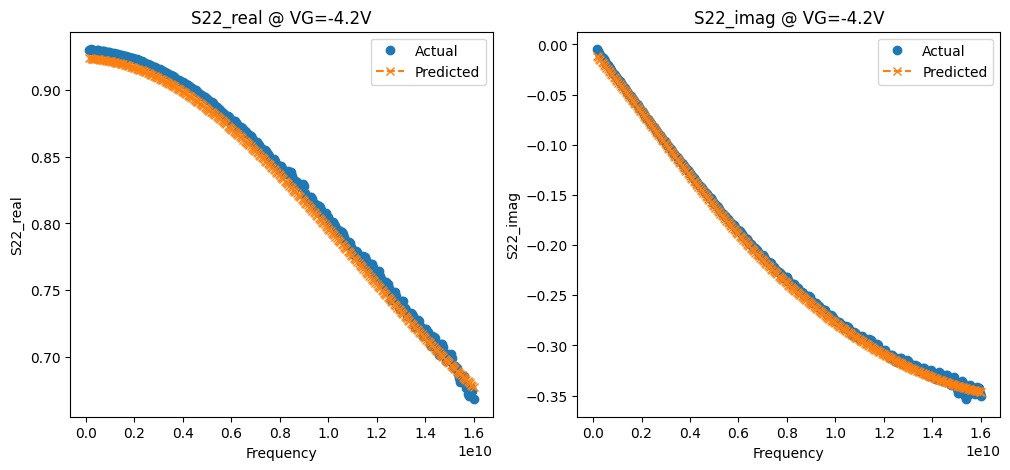

In [ ]:
plot_and_eval_for_vg_s22(-4.2)

In [ ]:
def plot_smith_for_vg_s22(vg_value, tol=1e-6):
    subset_s22 = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset_s22.empty:
        print(f"No data found for Gate Voltage = {vg_value} V")
        return

    # Actual S22
    freq_s22 = subset_s22['Frequency'].values
    s22_actual = subset_s22['S22_real'].values + 1j * subset_s22['S22_imag'].values

    # Predict S22
    X_s22 = subset_s22[['Frequency', 'Gate Voltage']].values
    X_scaled_s22 = scaler_x.transform(X_s22)
    pred_r_s22, pred_i_s22 = model_s22.predict(X_scaled_s22)
    pred_scaled_s22 = np.hstack([pred_r_s22, pred_i_s22])
    pred_s22 = scaler_y_s22.inverse_transform(pred_scaled_s22)
    s22_pred = pred_s22[:, 0] + 1j * pred_s22[:, 1]

    # Create scikit-rf networks
    freq_obj_s22 = Frequency.from_f(freq_s22, unit='Hz')
    ntw_actual_s22 = Network(frequency=freq_obj_s22, s=s22_actual.reshape(-1, 1, 1), name='Actual S22')
    ntw_pred_s22 = Network(frequency=freq_obj_s22, s=s22_pred.reshape(-1, 1, 1), name='Predicted S22')

    # Plot Smith chart
    plt.figure(figsize=(8, 8))
    ntw_actual_s22.plot_s_smith(m=0, n=0, label='Actual S22', marker='o', markersize=5, markerfacecolor='green', linestyle='None')
    ntw_pred_s22.plot_s_smith(m=0, n=0, label='Predicted S22', marker='.', markersize=2, linestyle='None')
    plt.title(f'Smith Chart: S22 @ VG = {vg_value} V')
    plt.legend()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


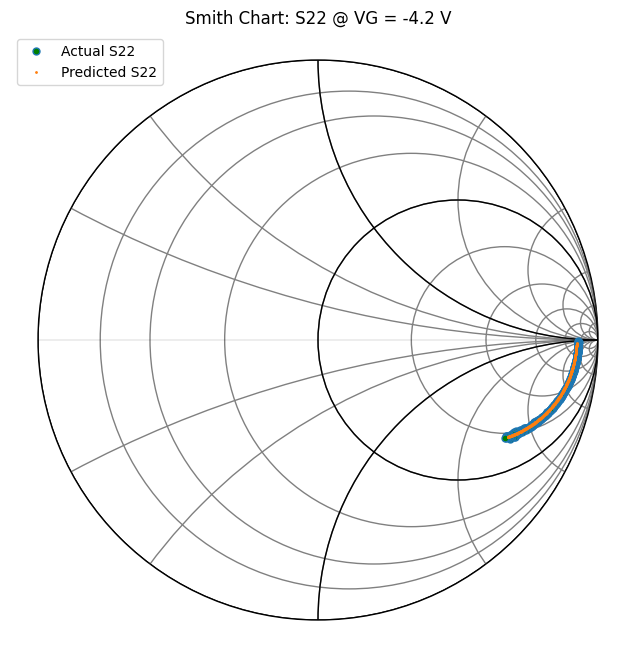

In [ ]:
plot_smith_for_vg_s22(-4.2)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1 & 2. Load and filter (f <= 1.6e10) & vd == 10
df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
df_filtered = df[(df['Frequency'] <= 1.6e10) & (df['Drain Voltage'] == 10)]

# 3. Train/test split
train_mask = (
    (df_filtered['Gate Voltage'] >= -3.9) &
    (df_filtered['Gate Voltage'] <= 0) &
    (df_filtered['Frequency'] <= 1.4e10)
)
train_df = df_filtered[train_mask]
test_df  = df_filtered[~train_mask]

# Features & targets
X_train = train_df[['Frequency', 'Gate Voltage']].values
X_test  = test_df[['Frequency', 'Gate Voltage']].values

y_train = train_df[['S12_real', 'S12_imag']].values
y_test  = test_df[['S12_real', 'S12_imag']].values

# Scale
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_x.transform(X_train)
X_test_s  = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# Build dual-output model
def build_model():
    inp = layers.Input(shape=(2,))
    x = layers.Dense(64, activation='swish')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dense(64, activation='swish')(x)
    out_r = layers.Dense(1)(x)
    out_i = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=[out_r, out_i])
    model.compile(optimizer='adam', loss='mse')
    return model

model_s12 = build_model()
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model_s12.fit(
    X_train_s, [y_train_s[:,0], y_train_s[:,1]],
    validation_split=0,
    epochs=100,
    batch_size=8,
    callbacks=[es],
    verbose=1
)

# Predict
pred_r_s12, pred_i_s12 = model_s12.predict(X_test_s)
pred_scaled_s12 = np.hstack([pred_r_s12, pred_i_s12])  # shape: (N, 2)
pred_s12 = scaler_y.inverse_transform(pred_scaled_s12)
pred_real_s12, pred_imag_s12 = pred_s12[:, 0], pred_s12[:, 1]

# True
true_real_s12, true_imag_s12 = y_test[:, 0], y_test[:, 1]

# Error metrics
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

print("\n=== Test Set Error Metrics ===")
print(f"S12_real → MRE: {mean_relative_error(true_real_s12, pred_real_s12):.6f}, MAE: {mean_absolute_error(true_real_s12, pred_real_s12):.6f}, MSE: {mean_squared_error(true_real_s12, pred_real_s12):.6f}")
print(f"S12_imag → MRE: {mean_relative_error(true_imag_s12, pred_imag_s12):.6f}, MAE: {mean_absolute_error(true_imag_s12, pred_imag_s12):.6f}, MSE: {mean_squared_error(true_imag_s12, pred_imag_s12):.6f}")


Epoch 1/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - dense_34_loss: 0.0651 - dense_35_loss: 0.0786 - loss: 0.1436
Epoch 2/100
  53/1321 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - dense_34_loss: 0.0153 - dense_35_loss: 0.0107 - loss: 0.0260

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: dense_34_loss,dense_35_loss,loss
  current = self.get_monitor_value(logs)


1321/1321 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_34_loss: 0.0088 - dense_35_loss: 0.0098 - loss: 0.0187
Epoch 3/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - dense_34_loss: 0.0073 - dense_35_loss: 0.0091 - loss: 0.0164
Epoch 4/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - dense_34_loss: 0.0068 - dense_35_loss: 0.0094 - loss: 0.0162
Epoch 5/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dense_34_loss: 0.0059 - dense_35_loss: 0.0081 - loss: 0.0140
Epoch 6/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - dense_34_loss: 0.0054 - dense_35_loss: 0.0077 - loss: 0.0131
Epoch 7/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - dense_34_loss: 0.0065 - dense_35_loss: 0.0076 - loss: 0.0141
Epoch 8/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_34_loss: 0.0054 - dense_35_loss: 0.0073 - loss: 0.0127
Epoch 9/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - dense_34_loss: 0.0053 - dense_35_loss: 0.0064 - loss: 0.0117
Epoch 10/100
1321/1321 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - dense_34_

In [ ]:
def plot_and_eval_for_vg_s12(vg_value, tol=1e-6):
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value}V")
        return

    # Prepare input
    X_sub = subset[['Frequency', 'Gate Voltage']].values
    Xs = scaler_x.transform(X_sub)

    # Predict (scaled), then inverse transform
    pred_r_s12, pred_i_s12 = model_s12.predict(Xs)
    pred_scaled_s12 = np.hstack([pred_r_s12, pred_i_s12])
    pred_s12 = scaler_y.inverse_transform(pred_scaled_s12)
    pred_real_s12, pred_imag_s12 = pred_s12[:, 0], pred_s12[:, 1]

    # True values
    actual_real_s12 = subset['S12_real'].values
    actual_imag_s12 = subset['S12_imag'].values

    # Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def mre(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre_s12, real_mae_s12, real_mse_s12 = mre(actual_real_s12, pred_real_s12), mean_absolute_error(actual_real_s12, pred_real_s12), mean_squared_error(actual_real_s12, pred_real_s12)
    imag_mre_s12, imag_mae_s12, imag_mse_s12 = mre(actual_imag_s12, pred_imag_s12), mean_absolute_error(actual_imag_s12, pred_imag_s12), mean_squared_error(actual_imag_s12, pred_imag_s12)

    print(f"S12_real @ VG={vg_value}V → MRE={real_mre_s12:.6f}, MAE={real_mae_s12:.6f}, MSE={real_mse_s12:.6f}")
    print(f"S12_imag @ VG={vg_value}V → MRE={imag_mre_s12:.6f}, MAE={imag_mae_s12:.6f}, MSE={imag_mse_s12:.6f}")

    # Plot
    freq = subset['Frequency'].values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq, actual_real_s12, 'o', label='Actual')
    plt.plot(freq, pred_real_s12, 'x--', label='Predicted')
    plt.title(f'S12_real @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S12_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq, actual_imag_s12, 'o', label='Actual')
    plt.plot(freq, pred_imag_s12, 'x--', label='Predicted')
    plt.title(f'S12_imag @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S12_imag')
    plt.legend()

    plt.tight_layout()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
S12_real @ VG=-4.2V → MRE=0.217127, MAE=0.001633, MSE=0.000008
S12_imag @ VG=-4.2V → MRE=0.057286, MAE=0.001354, MSE=0.000004


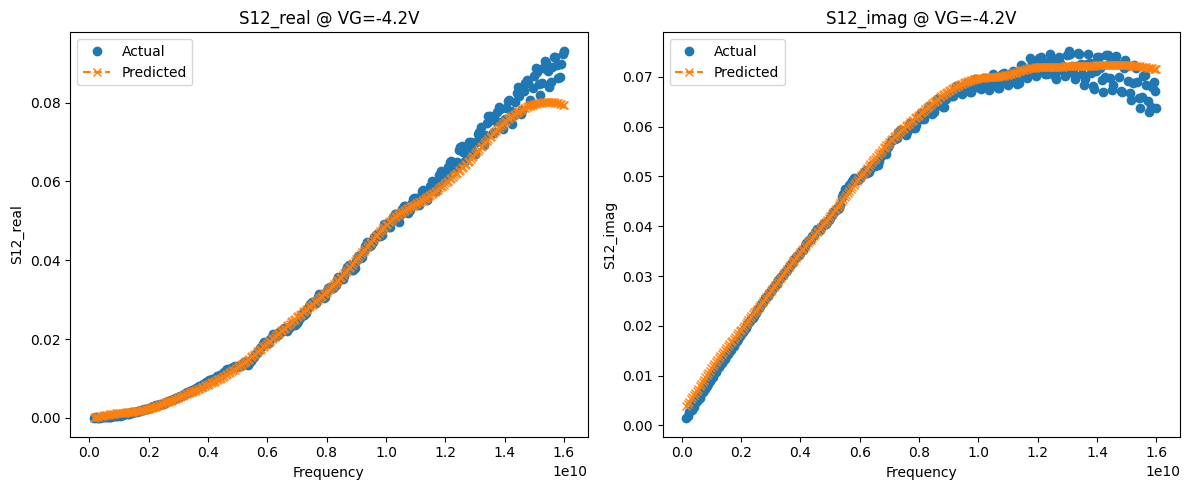

In [ ]:
plot_and_eval_for_vg_s12(-4.2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_s12_db_for_vg(vg_value, tol=1e-6):
    """
    Plot actual vs. predicted |S12| in dB vs. Frequency for a given Gate Voltage.

    Relies on globals:
      - df_filtered : DataFrame with ['Frequency','Gate Voltage','S12_real','S12_imag']
      - scaler_x    : fitted StandardScaler for input features
      - scaler_y    : fitted StandardScaler for S12 outputs
      - model_s12   : trained Keras model predicting [S12_real, S12_imag]
    """
    # 1) Filter for the requested VG
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value} V")
        return

    # 2) Actual complex S12 and convert to dB
    freq = subset['Frequency'].values
    s12_act = subset['S12_real'].values + 1j * subset['S12_imag'].values
    s12_act_db = 20 * np.log10(np.abs(s12_act) + 1e-12)

    # 3) Predict (scaled inputs → model → inverse-scale outputs)
    X = subset[['Frequency','Gate Voltage']].values
    Xs = scaler_x.transform(X)
    pred_r, pred_i = model_s12.predict(Xs)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    s12_pred = pred[:,0] + 1j * pred[:,1]
    s12_pred_db = 20 * np.log10(np.abs(s12_pred) + 1e-12)

    # 4) Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, s12_act_db, 'o-', label='Actual |S12| (dB)')
    plt.plot(freq, s12_pred_db, 'x--', label='Predicted |S12| (dB)')
    plt.title(f'S12 Magnitude (dB) vs Frequency @ VG = {vg_value} V')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S12| (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


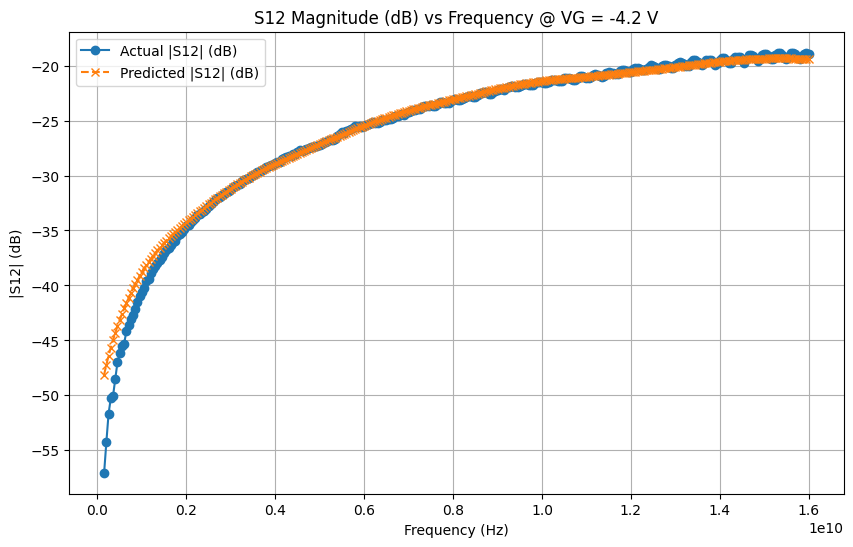

In [ ]:
plot_s12_db_for_vg(-4.2)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 1 & 2. Load and filter (f <= 1.6e10) & vd == 10
df = pd.read_csv("/content/drive/MyDrive/compiled_s_parameters.csv")
df_filtered = df[(df['Frequency'] <= 1.6e10) & (df['Drain Voltage'] == 10)]

# 3. Train/test split
train_mask = (
    (df_filtered['Gate Voltage'] >= -3.9) &
    (df_filtered['Gate Voltage'] <= 0) &
    (df_filtered['Frequency'] <= 1.4e10)
)
train_df = df_filtered[train_mask]
test_df  = df_filtered[~train_mask]

# Features & targets
X_train = train_df[['Frequency', 'Gate Voltage']].values
X_test  = test_df[['Frequency', 'Gate Voltage']].values

y_train = train_df[['S21_real', 'S21_imag']].values
y_test  = test_df[['S21_real', 'S21_imag']].values

# Scale
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_s = scaler_x.transform(X_train)
X_test_s  = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train)
y_test_s  = scaler_y.transform(y_test)

# Build dual-output model
def build_model():
    inp = layers.Input(shape=(2,))
    x = layers.Dense(64, activation='swish')(inp)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.Dense(64, activation='swish')(x)
    out_r = layers.Dense(1)(x)
    out_i = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=[out_r, out_i])
    model.compile(optimizer='adam', loss='mse')
    return model

model_s21 = build_model()
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model_s21.fit(
    X_train_s, [y_train_s[:,0], y_train_s[:,1]],
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=[es],
    verbose=1
)

# Predict
pred_r_s21, pred_i_s21 = model_s21.predict(X_test_s)
pred_scaled_s21 = np.hstack([pred_r_s21, pred_i_s21])  # shape: (N, 2)
pred_s21 = scaler_y.inverse_transform(pred_scaled_s21)
pred_real_s21, pred_imag_s21 = pred_s21[:, 0], pred_s21[:, 1]

# True
true_real_s21, true_imag_s21 = y_test[:, 0], y_test[:, 1]

# Error metrics
def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

print("\n=== Test Set Error Metrics ===")
print(f"S21_real → MRE: {mean_relative_error(true_real_s21, pred_real_s21):.6f}, MAE: {mean_absolute_error(true_real_s21, pred_real_s21):.6f}, MSE: {mean_squared_error(true_real_s21, pred_real_s21):.6f}")
print(f"S21_imag → MRE: {mean_relative_error(true_imag_s21, pred_imag_s21):.6f}, MAE: {mean_absolute_error(true_imag_s21, pred_imag_s21):.6f}, MSE: {mean_squared_error(true_imag_s21, pred_imag_s21):.6f}")


Epoch 1/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - dense_40_loss: 0.0630 - dense_41_loss: 0.0879 - loss: 0.1509 - val_dense_40_loss: 0.0011 - val_dense_41_loss: 0.0071 - val_loss: 0.0081
Epoch 2/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - dense_40_loss: 0.0067 - dense_41_loss: 0.0084 - loss: 0.0150 - val_dense_40_loss: 0.0013 - val_dense_41_loss: 0.0031 - val_loss: 0.0043
Epoch 3/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_40_loss: 0.0069 - dense_41_loss: 0.0071 - loss: 0.0140 - val_dense_40_loss: 0.0075 - val_dense_41_loss: 0.0110 - val_loss: 0.0185
Epoch 4/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - dense_40_loss: 0.0064 - dense_41_loss: 0.0064 - loss: 0.0127 - val_dense_40_loss: 0.0035 - val_dense_41_loss: 0.0058 - val_loss: 0.0093
Epoch 5/100
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - dense_40_loss: 0.0062 - dense_41_loss: 0.0064 - loss: 0.0126 - val_dense_40_loss: 0.0041 - val_dense_41_loss: 0.0271 - val_loss: 0.0314
Epoch 6/100
1189/1189 ━━━━━━━━━━━━━

In [ ]:
def plot_and_eval_for_vg_s21(vg_value, tol=1e-6):
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value}V")
        return

    # Prepare input
    X_sub = subset[['Frequency', 'Gate Voltage']].values
    Xs = scaler_x.transform(X_sub)

    # Predict (scaled), then inverse transform
    pred_r_s21, pred_i_s21 = model_s21.predict(Xs)
    pred_scaled_s21 = np.hstack([pred_r_s21, pred_i_s21])
    pred_s21 = scaler_y.inverse_transform(pred_scaled_s21)
    pred_real_s21, pred_imag_s21 = pred_s21[:, 0], pred_s21[:, 1]

    # True values
    actual_real_s21 = subset['S21_real'].values
    actual_imag_s21 = subset['S21_imag'].values

    # Metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    def mre(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12)))

    real_mre_s21, real_mae_s21, real_mse_s21 = mre(actual_real_s21, pred_real_s21), mean_absolute_error(actual_real_s21, pred_real_s21), mean_squared_error(actual_real_s21, pred_real_s21)
    imag_mre_s21, imag_mae_s21, imag_mse_s21 = mre(actual_imag_s21, pred_imag_s21), mean_absolute_error(actual_imag_s21, pred_imag_s21), mean_squared_error(actual_imag_s21, pred_imag_s21)

    print(f"S21_real @ VG={vg_value}V → MRE={real_mre_s21:.6f}, MAE={real_mae_s21:.6f}, MSE={real_mse_s21:.6f}")
    print(f"S21_imag @ VG={vg_value}V → MRE={imag_mre_s21:.6f}, MAE={imag_mae_s21:.6f}, MSE={imag_mse_s21:.6f}")

    # Plot
    freq = subset['Frequency'].values
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(freq, actual_real_s21, 'o', label='Actual')
    plt.plot(freq, pred_real_s21, 'x--', label='Predicted')
    plt.title(f'S21_real @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S21_real')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(freq, actual_imag_s21, 'o', label='Actual')
    plt.plot(freq, pred_imag_s21, 'x--', label='Predicted')
    plt.title(f'S21_imag @ VG={vg_value}V')
    plt.xlabel('Frequency')
    plt.ylabel('S21_imag')
    plt.legend()

    plt.tight_layout()
    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
S21_real @ VG=-4V → MRE=0.013795, MAE=0.015296, MSE=0.000357
S21_imag @ VG=-4V → MRE=0.024409, MAE=0.008791, MSE=0.000133


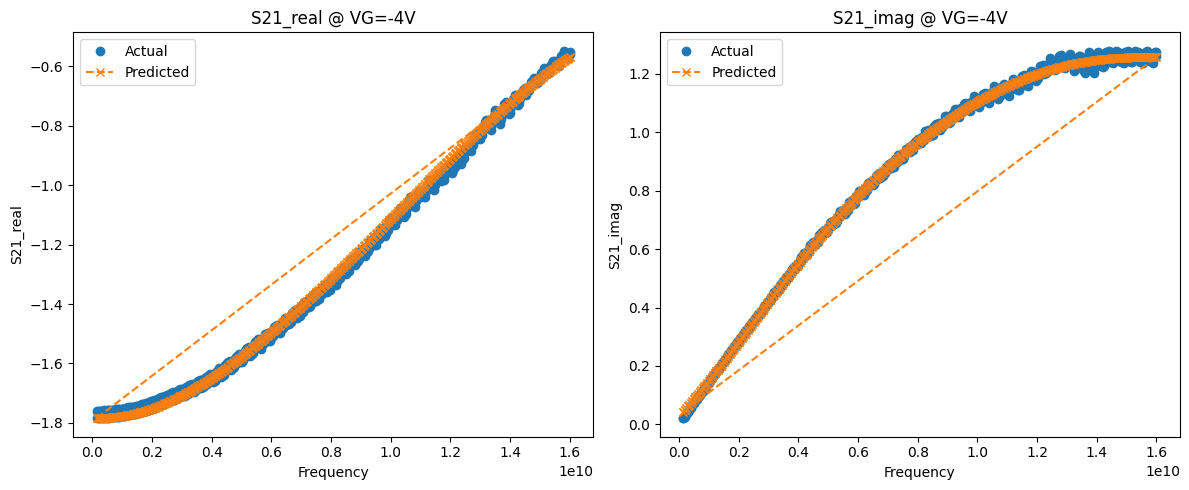

In [ ]:
plot_and_eval_for_vg_s21(-4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_s21_db_for_vg(vg_value, tol=1e-6):
    """
    Plot actual vs. predicted |S21| in dB vs. Frequency for a given Gate Voltage.

    Relies on globals:
      - df_filtered : DataFrame with ['Frequency','Gate Voltage','S21_real','S21_imag']
      - scaler_x    : fitted StandardScaler for input features
      - scaler_y    : fitted StandardScaler for S21 outputs
      - model_s21   : trained Keras model predicting [S21_real, S21_imag]
    """
    # 1) Filter for the requested VG
    subset = df_filtered[np.abs(df_filtered['Gate Voltage'] - vg_value) < tol]
    if subset.empty:
        print(f"No data found for Gate Voltage = {vg_value} V")
        return

    # 2) Actual complex S21 and convert to dB
    freq = subset['Frequency'].values
    s21_act = subset['S21_real'].values + 1j * subset['S21_imag'].values
    s21_act_db = 20 * np.log10(np.abs(s21_act) + 1e-12)

    # 3) Predict (scaled inputs → model → inverse-scale outputs)
    X = subset[['Frequency','Gate Voltage']].values
    Xs = scaler_x.transform(X)
    pred_r, pred_i = model_s21.predict(Xs)
    pred_scaled = np.hstack([pred_r, pred_i])
    pred = scaler_y.inverse_transform(pred_scaled)
    s21_pred = pred[:,0] + 1j * pred[:,1]
    s21_pred_db = 20 * np.log10(np.abs(s21_pred) + 1e-12)

    # 4) Plot
    plt.figure(figsize=(10, 6))
    plt.plot(freq, s21_act_db, 'o-', label='Actual |S21| (dB)')
    plt.plot(freq, s21_pred_db, 'x--', label='Predicted |S21| (dB)', markersize=3)
    plt.title(f'S21 Magnitude (dB) vs Frequency @ VG = {vg_value} V')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('|S21| (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


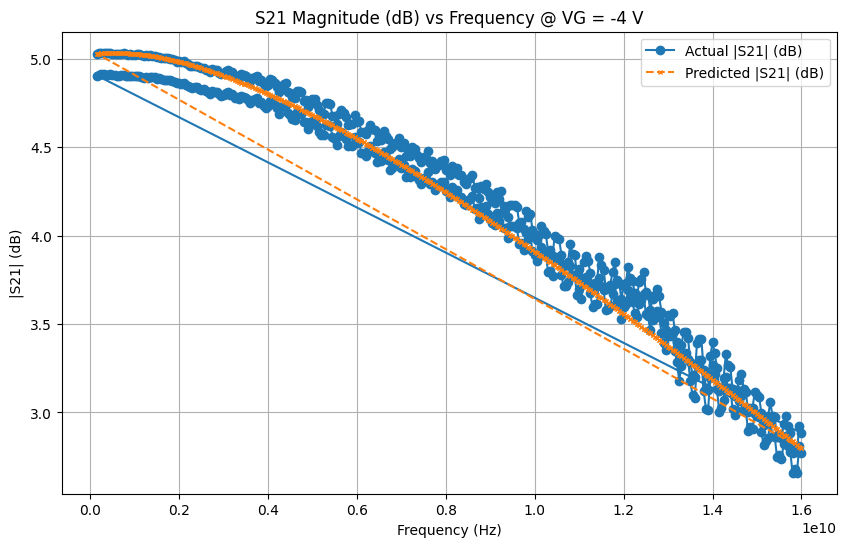

In [ ]:
plot_s21_db_for_vg(-4)